In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm import tqdm as tqdm

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

### Import dataset

In [10]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset_tr = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset_te = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset_tr,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_te, batch_size=1000,shuffle=True)

#load training data
images, labels = next(iter(train_loader))

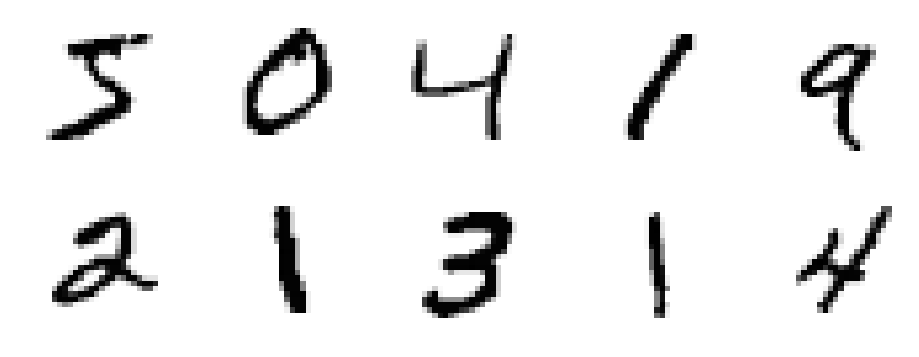

In [11]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');
plt.show()

### Define the model

In [12]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        #in_channels:Number of channels in the input image, out channels: number of channels in the output
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        #[batch, channel, height, width]
        #[64, 1, 28, 28]
        x = self.conv1(x) #[64, 6, 24, 24]
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #[64, 6, 12, 12]
        x = self.conv2(x) #[64, 6, 8, 8]
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) #[64, 6, 4, 4]
        x = x.view(-1, self.n_feature*4*4) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Train and test functions

In [28]:
loss_fn = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
    log_interval=100
    model.train() #set model in train mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        #loss = F.cross_entropy(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            
def test(model, device, test_loader):
    model.eval() #set model in test mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [29]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 1):
    train(model_cnn, device, train_loader, optimizer, epoch)
    test(model_cnn, device, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.325481
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.319495
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.506286
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.525032
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.382396
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.473994
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.170087
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.178940
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.301210
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.083209


TypeError: forward() got an unexpected keyword argument 'reduction'